In [1]:
# Leave lines below uncommented this if you get:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from losses import bce_weighted_dice_loss

In [2]:
from glomerulus import Glomerulus, Patch, KidneySampleDataset, get_glomeruli, generate_glomerulus_patches
from networks import CBAM_R2UNet_v2
from utils import read_tiff, dataset_label_mean
from losses import dice_loss

In [3]:
TEST_IMAGE_PATH = './kidney_dataset/train/aaa6a05cc.tiff'
TEST_LABEL_PATH = './kidney_dataset/train/aaa6a05cc.json'

test_image = read_tiff(TEST_IMAGE_PATH)


C:\Users\iraha\anaconda3\lib\site-packages\rasterio\__init__.py:320: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
model = CBAM_R2UNet_v2((128, 128), (512, 512)).cuda()
glo =0.8
remain = np.round(1-glo, 1)
model.load_state_dict(torch.load(f'./dataset_ratio_models/CBAM_R2UNet_v2_train_{glo}_{remain}.npy_Weighted_BCE_Dice_t1000_b100_best_loss.npz'))

<All keys matched successfully>

##### Downsample the image by calculating the mean of 512x512 array (may not need to run)
Compare and observe the difference between original image, downsampled image, and transformed image

In [12]:
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
y=[]
for idx_y in tqdm(range(0, test_image.shape[1], 512)):
    x=[]
    for idx_x in range(0, test_image.shape[2], 512):
        center_x = idx_x + 512 // 2
        center_y = idx_y + 512 // 2
        test_patch = Patch(
            center_x = center_x,
            center_y = center_y,
            theta = 0,
            patch_size = 512,
            glomeruli = test_glomeruli,
            image = test_image
        ).render_image()
        x.append(np.mean(test_patch[0]))
    y.append(x)
my_array = np.array(y)

  0%|          | 0/37 [00:00<?, ?it/s]

In [13]:
y=[]
for idx_y in range(my_array.shape[0]):
    x=[]
    for idx_x in range(my_array.shape[1]):
        if my_array[idx_y][idx_x] < 205 and my_array[idx_y][idx_x]>100:
            x.append(255)
        else:
            x.append(0)
    y.append(x)

In [14]:
new_array = np.array(y)

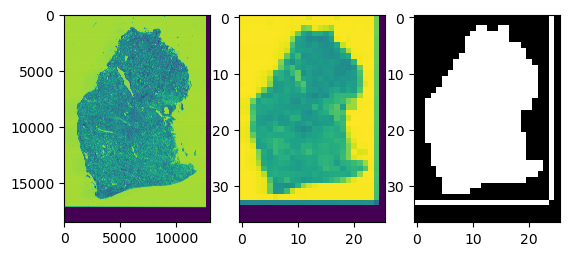

In [16]:
plt.subplot(1,3,1)
plt.imshow(test_image[0])
plt.subplot(1,3,2)
plt.imshow(my_array)
plt.subplot(1,3,3)
plt.imshow(new_array,cmap='gray')
plt.show()

To remove the background, if 100 < value < 205：value=255; else: value = 0.
We will test our model on those white part

### Test model and Visualize


In [5]:
def test(model,test_image,test_glomeruli,image_value_lb = 100,image_value_ub = 205):
    out_img = np.zeros((
        int(np.ceil(test_image.shape[1] / 512) * 512),
        int(np.ceil(test_image.shape[2] / 512) * 512)
    ))
    intersection = 0
    union = 0
    smooth = 0.00000001
    for idx_y in tqdm(range(0, test_image.shape[1], 512)):
        for idx_x in range(0, test_image.shape[2], 512):
            center_x = idx_x + 512 // 2
            center_y = idx_y + 512 // 2
            test_patch = Patch(
                center_x = center_x,
                center_y = center_y,
                theta = 0,
                patch_size = 512,
                glomeruli = test_glomeruli,
                image = test_image
            )
            image = test_patch.render_image()
            label = test_patch.render_mask()
            mean = np.mean(image[0])
            if mean >image_value_ub or mean <image_value_lb:
                continue
            out = model.forward(torch.unsqueeze(torch.tensor(image), 0).type(torch.cuda.FloatTensor))
            out_array = out.cpu().detach().numpy()[0][0]
            intersection += np.sum(out_array * label[0])
            union += np.sum(out_array) + np.sum(label[0])
            out_img[idx_y: idx_y+512, idx_x: idx_x+512] = out_array

    diceLoss = 1 - (2 * intersection + smooth) / (union + smooth)
    print("Dice_loss = ",diceLoss )
    return out_img , diceLoss

In [6]:
glos = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
diceLosses = []
for glo in glos:
    model = CBAM_R2UNet_v2((128, 128), (512, 512)).cuda()
    remain = 1-glo
    model.load_state_dict(torch.load(f'./dataset_ratio_models/CBAM_R2UNet_v2_train_{glo:.1f}_{remain:.1f}.npy_Weighted_BCE_Dice_t1000_b100_best_loss.npz'))
    test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
    out_img , diceLoss = test(model,test_image,test_glomeruli)
    diceLosses.append(diceLoss)

  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7799545532600982


  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7464402780151423


  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7641030924218325


  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7138627907716881


  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.6762517148974811


  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.6931881677256011


  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7412195423048337


  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7262669209377736


  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7586000574970215


  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7611398999203471


  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7533387371822492


In [7]:
glos = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for i in range(len(glos)):
    print(f"Glo = {glos[i]:.1f}, Random = {(1-glos[i]):.1f}, Dice Loss = {diceLosses[i]}")

Glo = 0.0, Random = 1.0, Dice Loss = 0.7799545532600982
Glo = 0.1, Random = 0.9, Dice Loss = 0.7464402780151423
Glo = 0.2, Random = 0.8, Dice Loss = 0.7641030924218325
Glo = 0.3, Random = 0.7, Dice Loss = 0.7138627907716881
Glo = 0.4, Random = 0.6, Dice Loss = 0.6762517148974811
Glo = 0.5, Random = 0.5, Dice Loss = 0.6931881677256011
Glo = 0.6, Random = 0.4, Dice Loss = 0.7412195423048337
Glo = 0.7, Random = 0.3, Dice Loss = 0.7262669209377736
Glo = 0.8, Random = 0.2, Dice Loss = 0.7586000574970215
Glo = 0.9, Random = 0.1, Dice Loss = 0.7611398999203471
Glo = 1.0, Random = 0.0, Dice Loss = 0.7533387371822492


In [8]:
glo = 0.4
model = CBAM_R2UNet_v2((128, 128), (512, 512)).cuda()
remain = 1-glo
model.load_state_dict(torch.load(f'./dataset_ratio_models/CBAM_R2UNet_v2_train_{glo:.1f}_{remain:.1f}.npy_Weighted_BCE_Dice_t1000_b100_best_loss.npz'))
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
out_img , diceLoss = test(model,test_image,test_glomeruli)

  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.6762517148974811


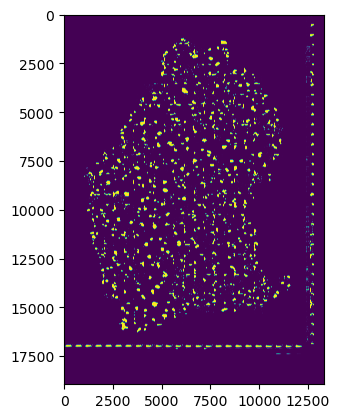

In [9]:
plt.imshow(out_img)

In [10]:
glo = 0.1
model = CBAM_R2UNet_v2((128, 128), (512, 512)).cuda()
remain = 1-glo
model.load_state_dict(torch.load(f'./dataset_ratio_models/CBAM_R2UNet_v2_train_{glo:.1f}_{remain:.1f}.npy_Weighted_BCE_Dice_t1000_b100_best_loss.npz'))
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
out_img2 , diceLoss = test(model,test_image,test_glomeruli)
out_img += out_img2
# plt.imshow(out_img2)

  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7464402780151423


In [11]:
glo = 0.7
model = CBAM_R2UNet_v2((128, 128), (512, 512)).cuda()
remain = 1-glo
model.load_state_dict(torch.load(f'./dataset_ratio_models/CBAM_R2UNet_v2_train_{glo:.1f}_{remain:.1f}.npy_Weighted_BCE_Dice_t1000_b100_best_loss.npz'))
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
out_img2 , diceLoss = test(model,test_image,test_glomeruli)
out_img += out_img2
# plt.imshow(out_img2)

  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7262669209377736


In [12]:
glo = 0.3
model = CBAM_R2UNet_v2((128, 128), (512, 512)).cuda()
remain = 1-glo
model.load_state_dict(torch.load(f'./dataset_ratio_models/CBAM_R2UNet_v2_train_{glo:.1f}_{remain:.1f}.npy_Weighted_BCE_Dice_t1000_b100_best_loss.npz'))
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
out_img2 , diceLoss = test(model,test_image,test_glomeruli)
out_img += out_img2
# plt.imshow(out_img2)

  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7138627907716881


In [13]:
glo = 0.5
model = CBAM_R2UNet_v2((128, 128), (512, 512)).cuda()
remain = 1-glo
model.load_state_dict(torch.load(f'./dataset_ratio_models/CBAM_R2UNet_v2_train_{glo:.1f}_{remain:.1f}.npy_Weighted_BCE_Dice_t1000_b100_best_loss.npz'))
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
out_img2 , diceLoss = test(model,test_image,test_glomeruli)
out_img += out_img2
# plt.imshow(out_img2)

  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.6931881677256011


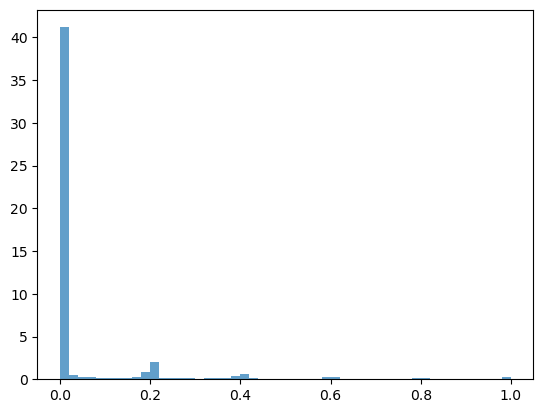

In [14]:
out_img /= 5
plt.hist(out_img.flatten(), bins=50, density=True, alpha=0.7)
plt.show()
#out_img = np.where(out_img<0.5,0,1)
#plt.imshow(out_img)

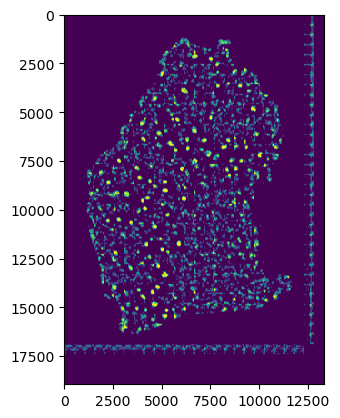

In [15]:
plt.imshow(out_img)

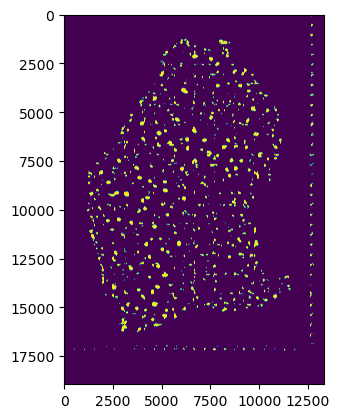

In [16]:
out_img2 = np.where(out_img<0.5,0,1) # 3 models agree
plt.imshow(out_img2)

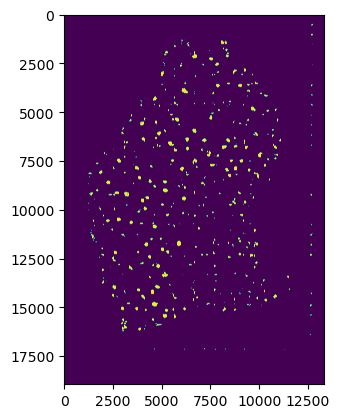

In [17]:
out_img2 = np.where(out_img<0.7,0,1) # 4 models agree
plt.imshow(out_img2)

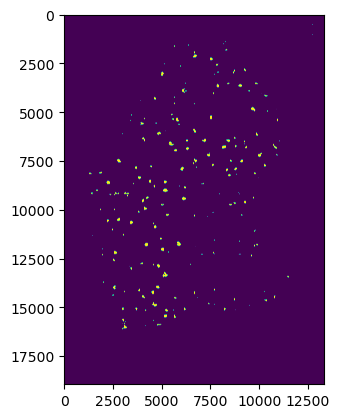

In [18]:
out_img2 = np.where(out_img<0.9,0,1) # all 5 models agree
plt.imshow(out_img2)

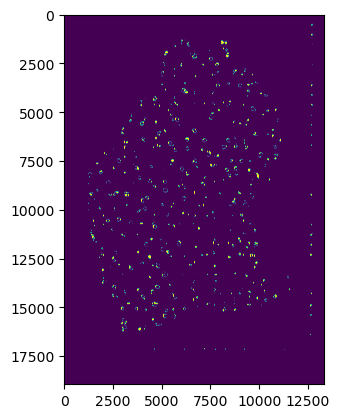

In [19]:
out_img2 = np.where(out_img>0.9,1,out_img) # all 5 models agree
out_img2 = np.where((out_img2>0.7) & (out_img2 < 0.9), 0.5 , 0) # 4 models agree
plt.imshow(out_img2)

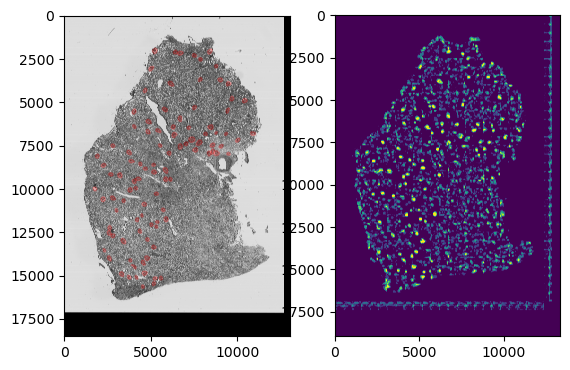

In [21]:
import json
from matplotlib.patches import Polygon
plt.subplot(1, 2, 1)
# Load label path from json file
kidney_label = json.load(open(TEST_LABEL_PATH))
for element in kidney_label:
    if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
        label = element['geometry']
        if label['type'] == 'Polygon':
            coordinates = label['coordinates'][0]

            # Create polygon from label coordinates and plot
            label_polygon = Polygon(coordinates, closed=True, color='red', alpha=0.2)
            ax = plt.gca()
            ax.add_patch(label_polygon)

imgplot = plt.imshow(test_image[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out_img)
plt.show()

In [22]:
import scipy
from scipy.ndimage import label, measurements
from scipy.stats import logistic

def get_connected_components(img):
    # Find connected components and calculate centroids
    img_binary = np.where(img > 0.5, 1, 0)
    labels, num_components = scipy.ndimage.label(img_binary)
    centroids = measurements.center_of_mass(img_binary, labels, range(1, num_components + 1))
    
    # Calculate the sizes of each component
    sizes = np.bincount(labels.ravel())[1:]
    
    return centroids, sizes

def is_glomerulus(label_path, x, y):
    # Load labels from json and plot glomerulus
    kidney_label = json.load(open(label_path))
    for element in kidney_label:
        if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
            label = element['geometry']
            if label['type'] == 'Polygon':
                coordinates = label['coordinates'][0]
                
                if shapely.geometry.Polygon(coordinates).contains(shapely.geometry.Point(x, y)):
                    return True
    return False
    
def plot_connected_components(img, label_path, component_lowerbound, component_upperbound):
    # Find connected components and calculate centroids
    img_binary = np.where(img > 0.5, 1, 0)
    labels, num_components = scipy.ndimage.label(img_binary)
    centroids = measurements.center_of_mass(img_binary, labels, range(1, num_components + 1))

    # Calculate the sizes of each component
    sizes = np.bincount(labels.ravel())[1:]

    plt.figure(figsize=(10, 10))

    plt.title(f'Connected Components ({component_lowerbound} < area < {component_upperbound})')
    plt.imshow(img_binary)
    
    # Plot connected component centroids
    for idx, centroid in enumerate(centroids):
        if sizes[idx] > component_lowerbound and sizes[idx] < component_upperbound:
            plt.plot([centroid[1]], [centroid[0]], marker='o', color='cyan', markersize=sizes[idx], alpha=0.2)

    # Load labels from json and plot glomerulus
    kidney_label = json.load(open(label_path))
    for element in kidney_label:
        if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
            label = element['geometry']
            if label['type'] == 'Polygon':
                coordinates = label['coordinates'][0]

                # Create polygon from label coordinates and plot
                ax = plt.gca()
                ax.add_patch(Polygon(coordinates, closed=True, color='red', alpha=0.5))

    plt.show()

### Calculate Size Distribution of Labeled Glomeruli

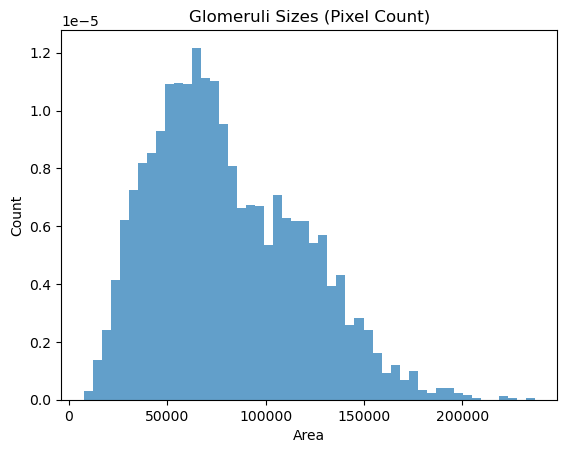

In [23]:
import json
from matplotlib.patches import Polygon
import shapely

image_names = [
    'afa5e8098',
    '4ef6695ce',
    'c68fe75ea',
    '26dc41664',
    '095bf7a1f',
    '54f2eec69',
    '1e2425f28',
    'e79de561c',
    'cb2d976f4',
    'b9a3865fc',
    '8242609fa',
    '0486052bb',
    '2f6ecfcdf',
    'b2dc8411c',
    'aaa6a05cc'
]

root_dir = './kidney_dataset/train'

glomerulus_sizes = []
glomerulus_coordinates = []

# Load label path from json file
for image_name in image_names:
    kidney_label = json.load(open(os.path.join(root_dir, image_name + '.json')))
    for element in kidney_label:
        if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
            label = element['geometry']
            if label['type'] == 'Polygon':
                coordinates = label['coordinates'][0]

#                 Create polygon from label coordinates and plot
                label_polygon = Polygon(coordinates, closed=True, color='red', alpha=0.2)

                glomerulus_sizes.append(shapely.geometry.Polygon(coordinates).area)
                glomerulus_coordinates.append(coordinates)
plt.title('Glomeruli Sizes (Pixel Count)')
plt.xlabel('Area')
plt.ylabel('Count')
_, _, _ = plt.hist(glomerulus_sizes, bins=50, density=True, alpha=0.7)

C:\Users\iraha\AppData\Local\Temp\ipykernel_7216\1290588252.py:9: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  centroids = measurements.center_of_mass(img_binary, labels, range(1, num_components + 1))


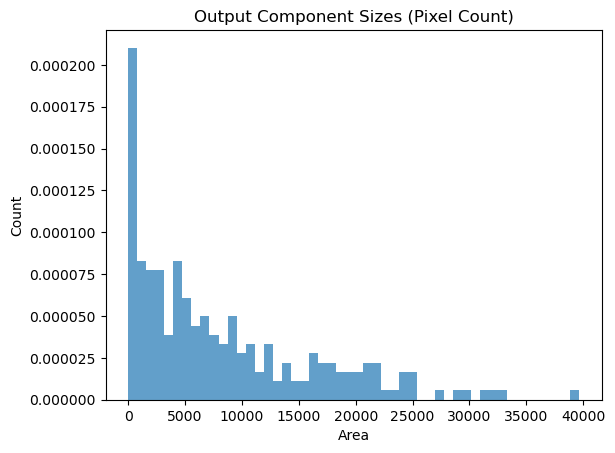

In [129]:
out_img2 = np.where(out_img<0.9,0,1) # all 5 models agree
centroids, sizes = get_connected_components(out_img2)
glomerulus_centroids = []

for idx, centroid in enumerate(centroids):
    if is_glomerulus(TEST_LABEL_PATH, centroid[0], centroid[1]):
        glomerulus_centroids.append(centroid)

plt.title('Output Component Sizes (Pixel Count)')
plt.xlabel('Area')
plt.ylabel('Count')
_, _, _ = plt.hist(sizes, bins=50, density=True, alpha=0.7)

In [130]:
glomerulus_centroids = []
glomerulus_centroid_sizes = []

for idx, centroid in enumerate(centroids):
    if is_glomerulus(TEST_LABEL_PATH, centroid[1], centroid[0]):
        glomerulus_centroids.append(centroid)
        glomerulus_centroid_sizes.append(sizes[idx])

In [131]:
source_median = np.median(glomerulus_sizes)
source_std = np.std(glomerulus_sizes)
target_median = np.median(glomerulus_centroid_sizes)
target_std = np.std(glomerulus_centroid_sizes)

# Perform the z-score transformation to match the median and standard deviation
mapped_data = [(x - source_median) * (target_std / source_std) + target_median for x in glomerulus_sizes]

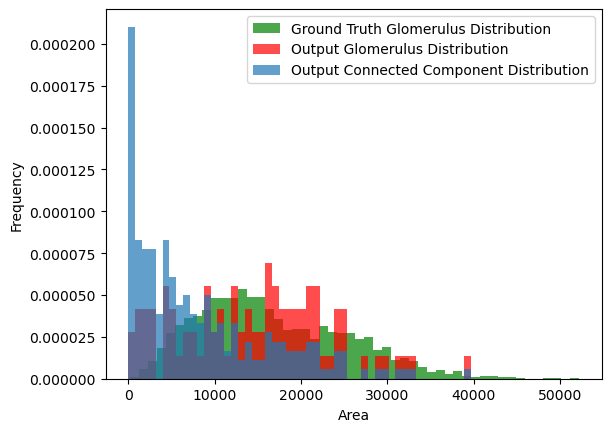

In [133]:
_, _, _ = plt.hist(mapped_data, bins=50, density=True, alpha=0.7, color='green', label='Ground Truth Glomerulus Distribution')
_, _, _ = plt.hist(glomerulus_centroid_sizes, bins=50, density=True, color='red', alpha=0.7, label='Output Glomerulus Distribution')
_, _, _ = plt.hist(sizes, bins=50, density=True, alpha=0.7, label='Output Connected Component Distribution')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.legend()

In [28]:
 out_img2 = np.where(out_img>0.9,1,out_img) # 5 models agree
# plot_connected_components(out_img2, TEST_LABEL_PATH, 5000, 50000)
components = get_connected_components(out_img2)

C:\Users\iraha\AppData\Local\Temp\ipykernel_17708\1290588252.py:9: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  centroids = measurements.center_of_mass(img_binary, labels, range(1, num_components + 1))


In [ ]:
component_lowerbound = 5000
component_upperbound = 50000
plt.figure(figsize=(10, 10))

plt.title(f'Connected Components ({component_lowerbound} < area < {component_upperbound})')
plt.imshow(out_img2)

centroids = components[0]
sizes = components[1]

# Plot connected component centroids
for idx, centroid in enumerate(centroids):
    
    if sizes[idx] > component_lowerbound and sizes[idx] < component_upperbound:
        plt.plot([centroid[1]], [centroid[0]], marker='o', color='cyan', markersize=sizes[idx], alpha=0.2)

# Load labels from json and plot glomerulus
kidney_label = json.load(open(TEST_LABEL_PATH))
for element in kidney_label:
    if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
        label = element['geometry']
        if label['type'] == 'Polygon':
            coordinates = label['coordinates'][0]

            # Create polygon from label coordinates and plot
            ax = plt.gca()
            ax.add_patch(Polygon(coordinates, closed=True, color='red', alpha=0.5))

In [33]:
centroid = []
for i in range(len(test_glomeruli)):
    x = test_glomeruli[i].centroid_x//512
    y = test_glomeruli[i].centroid_y//512
    centroid.append([x,y])

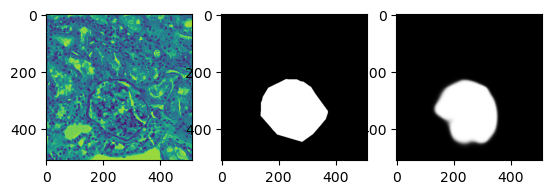

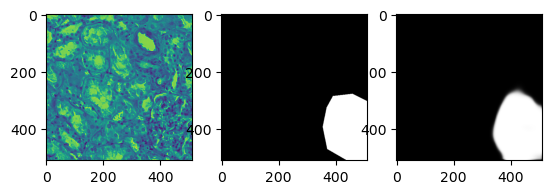

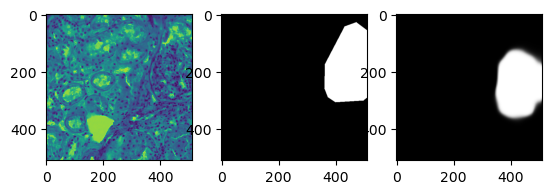

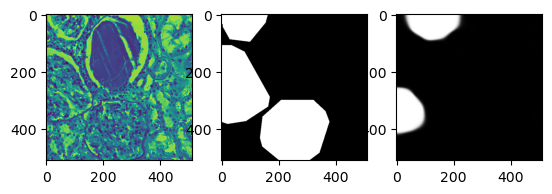

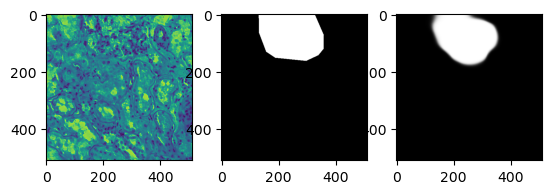

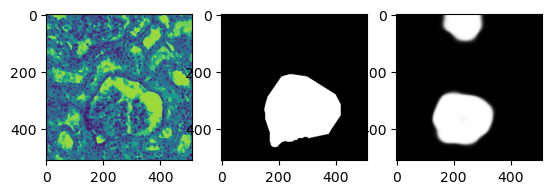

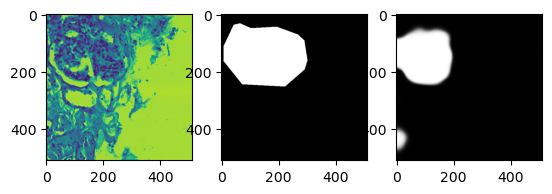

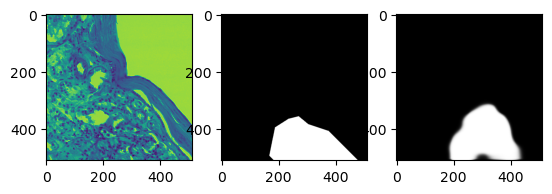

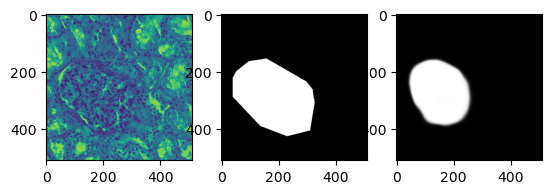

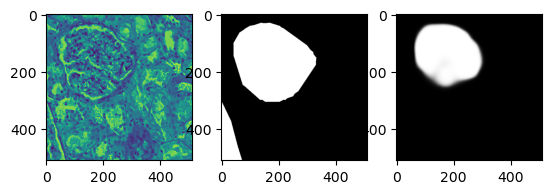

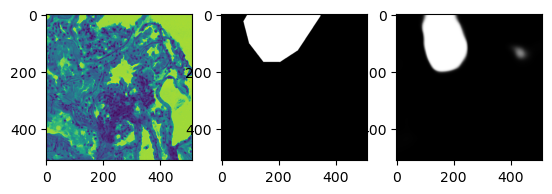

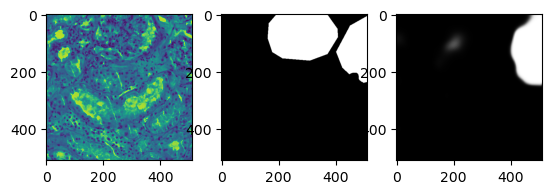

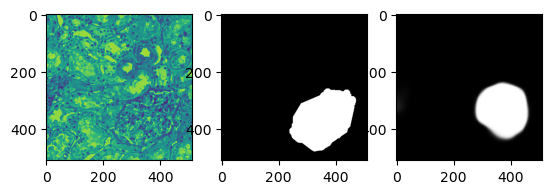

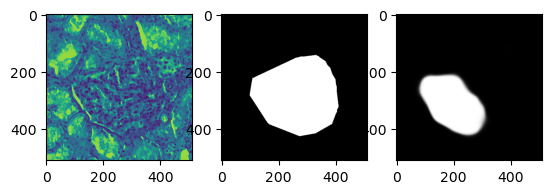

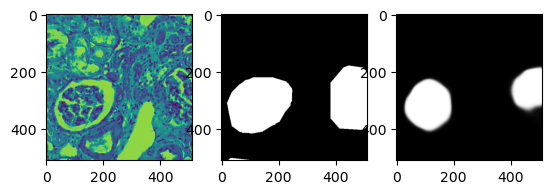

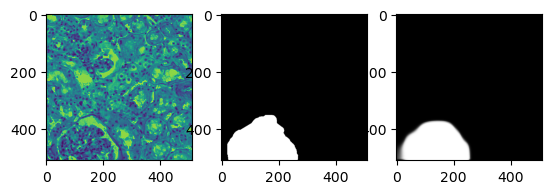

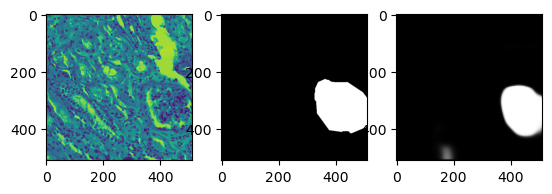

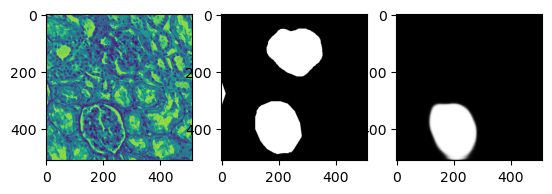

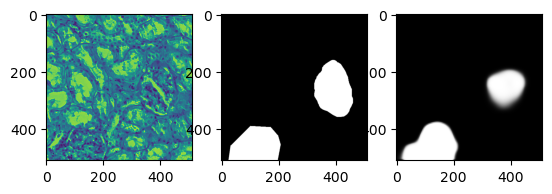

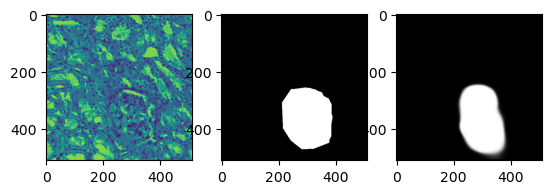

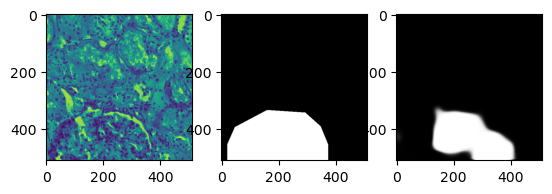

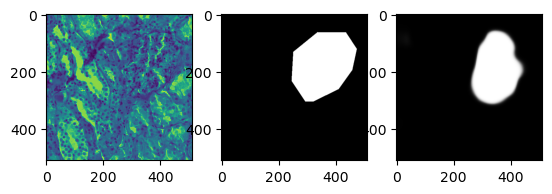

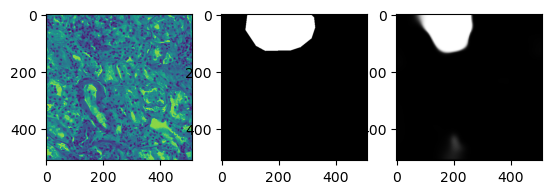

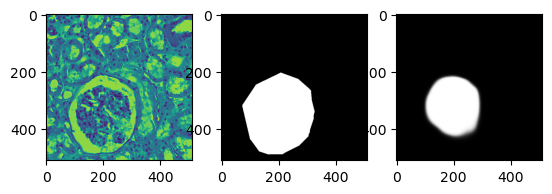

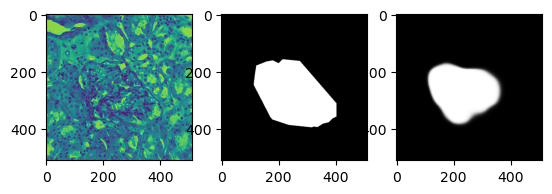

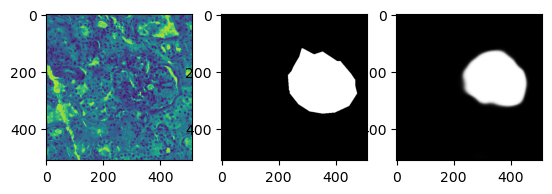

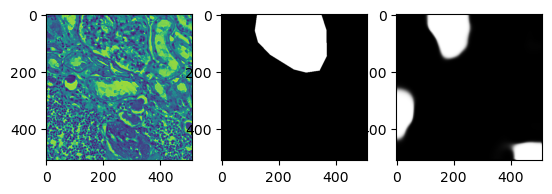

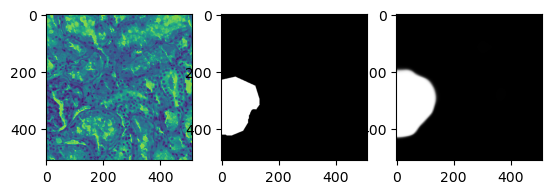

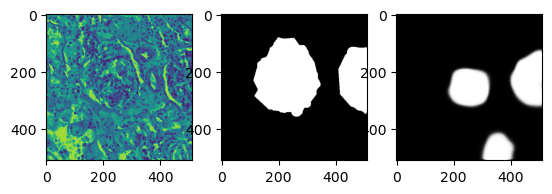

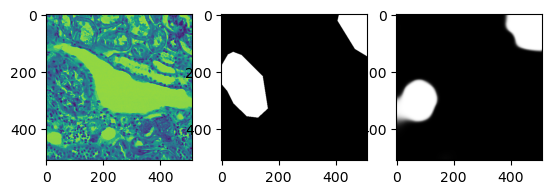

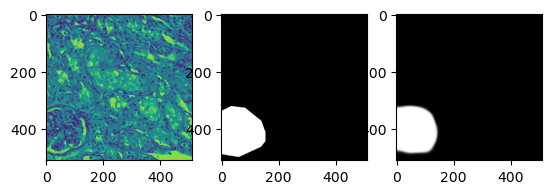

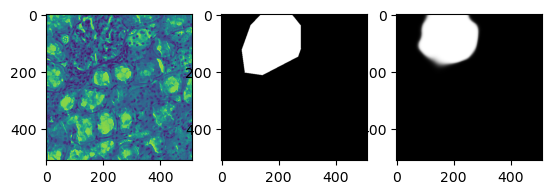

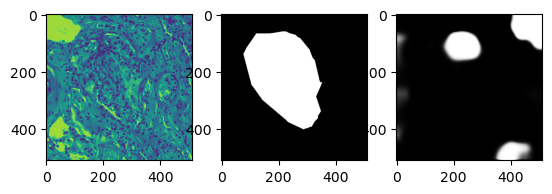

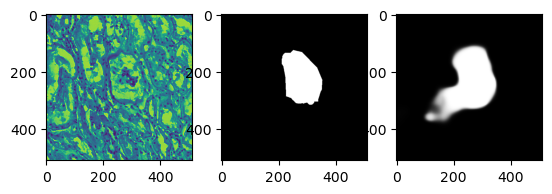

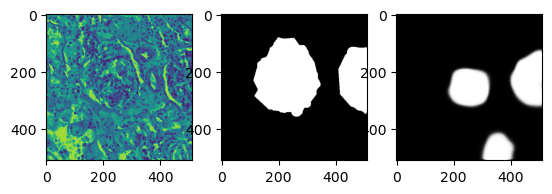

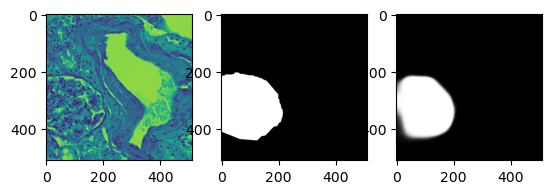

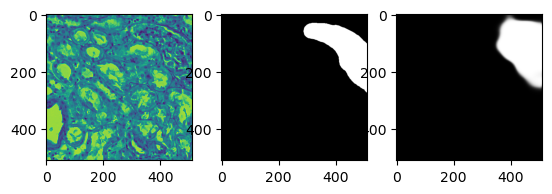

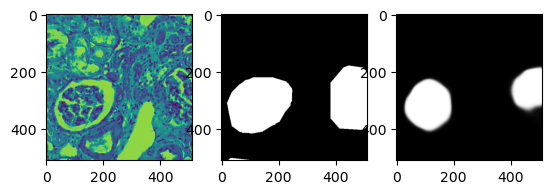

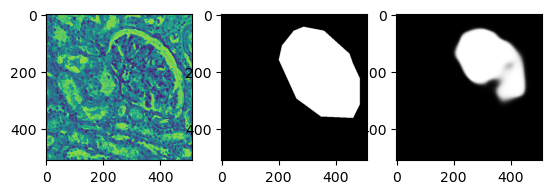

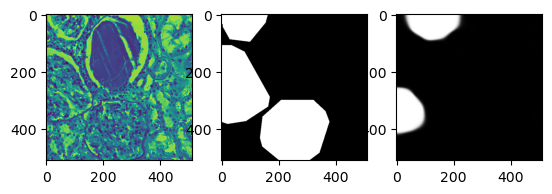

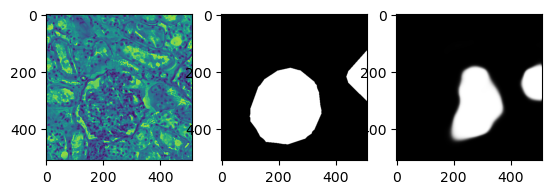

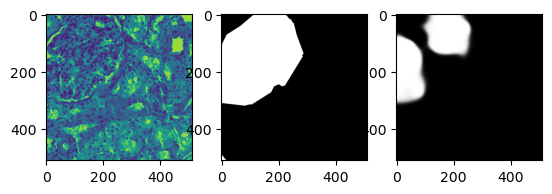

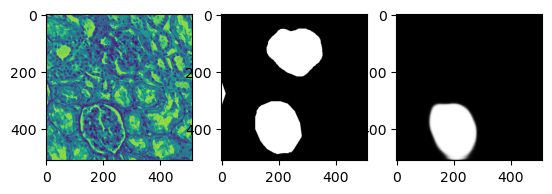

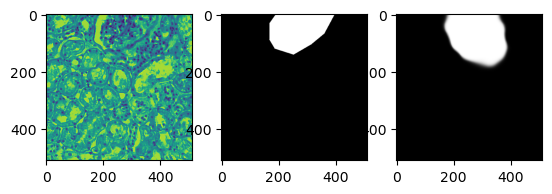

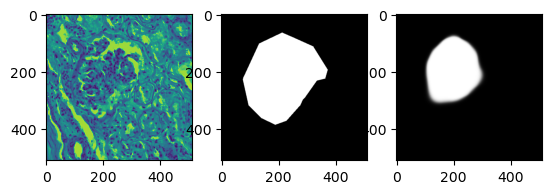

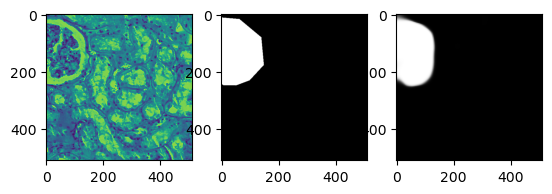

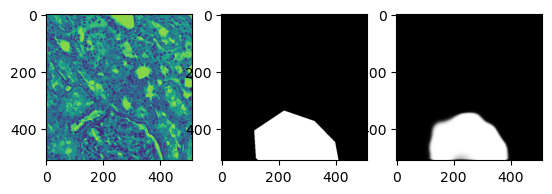

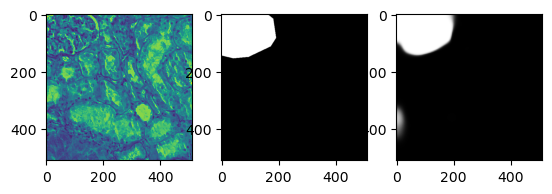

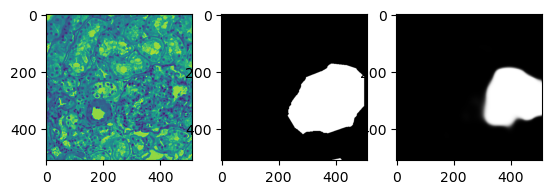

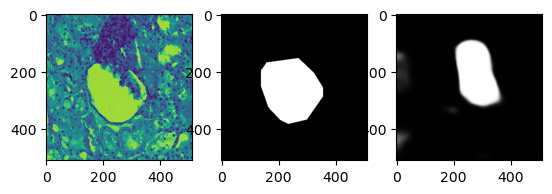

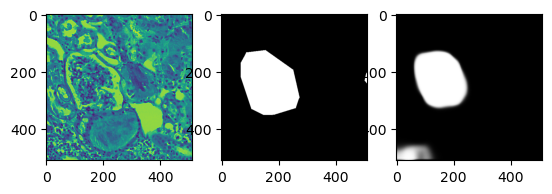

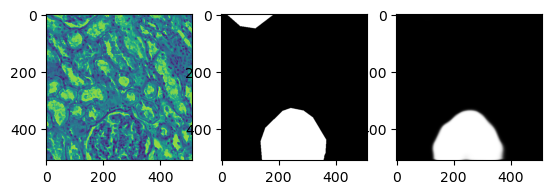

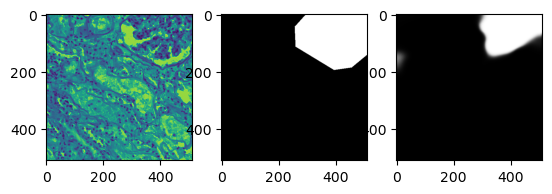

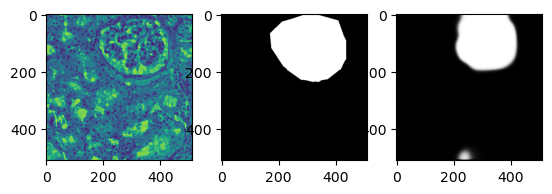

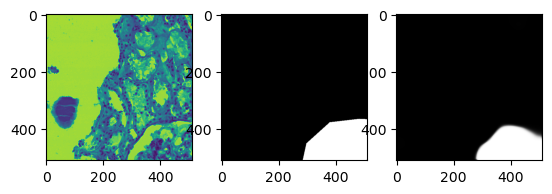

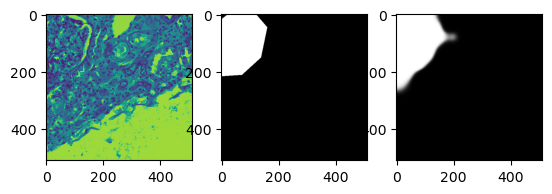

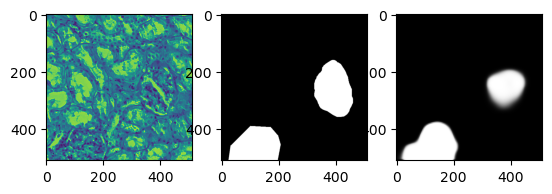

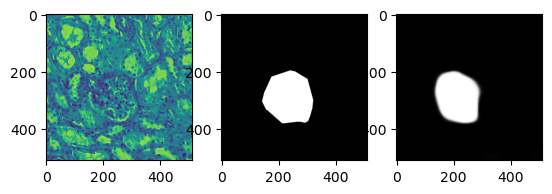

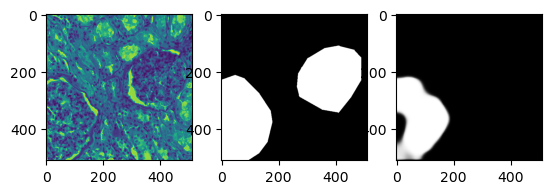

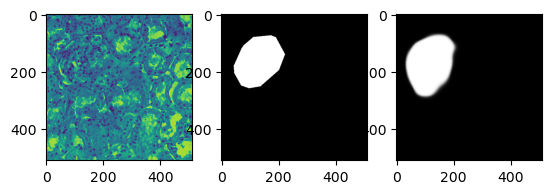

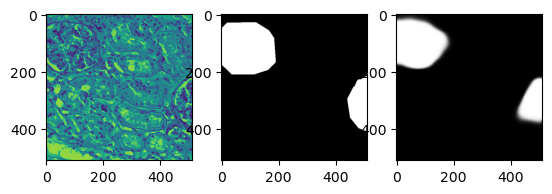

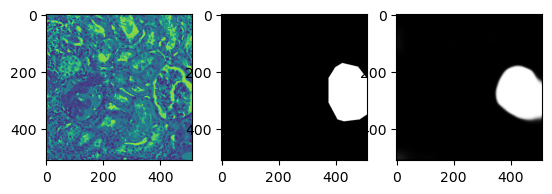

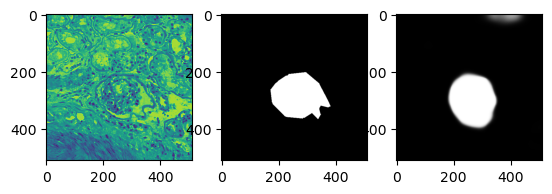

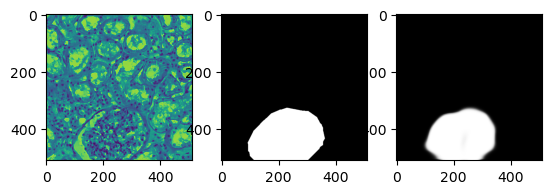

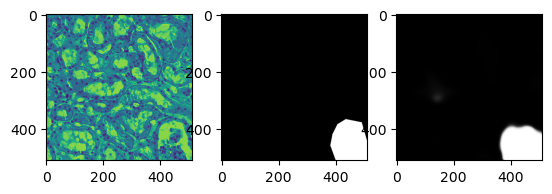

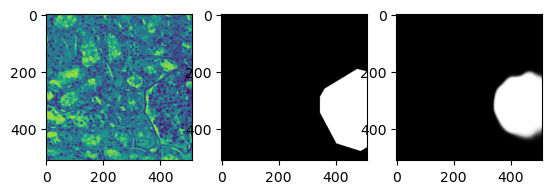

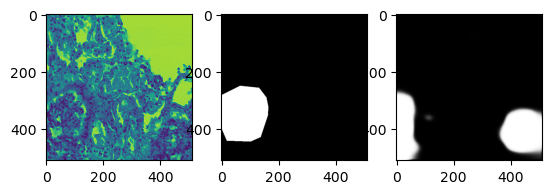

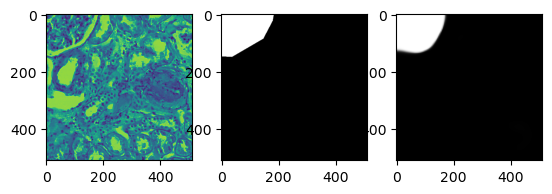

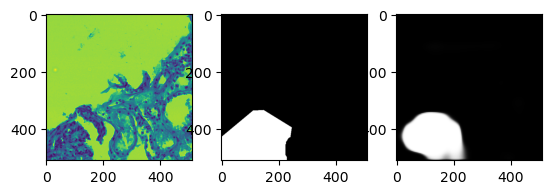

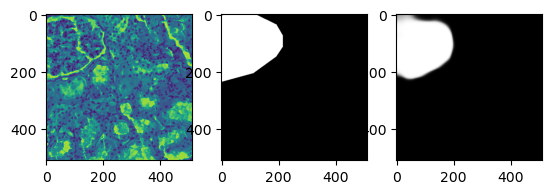

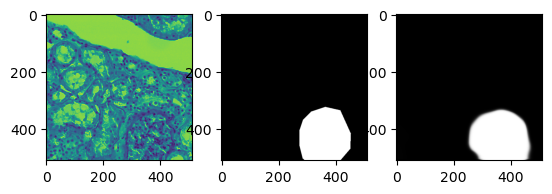

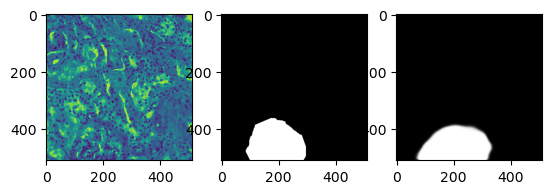

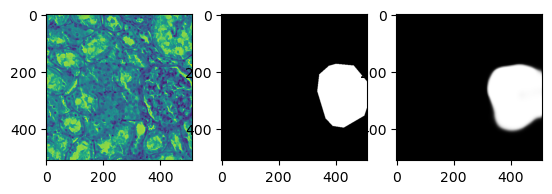

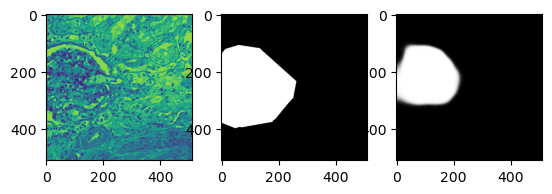

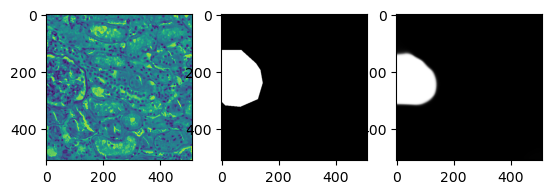

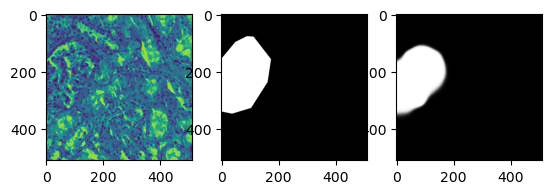

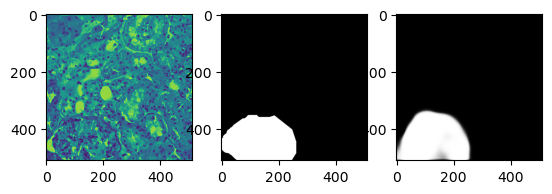

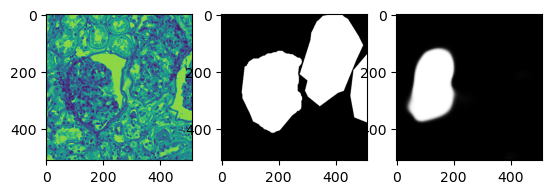

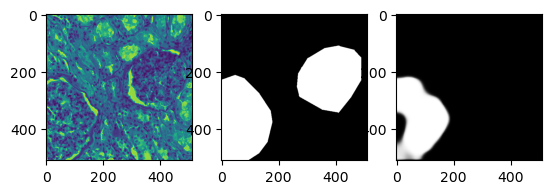

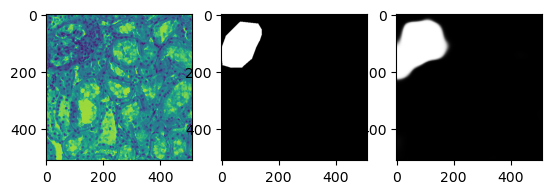

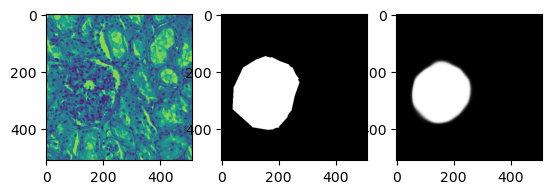

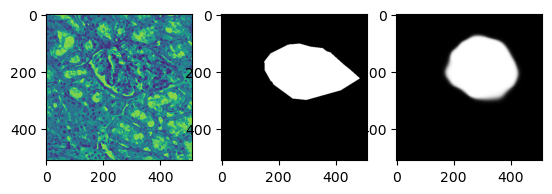

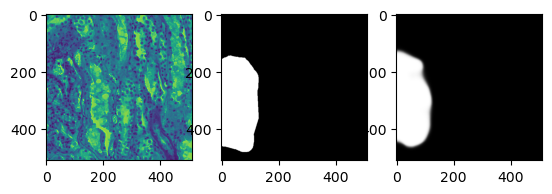

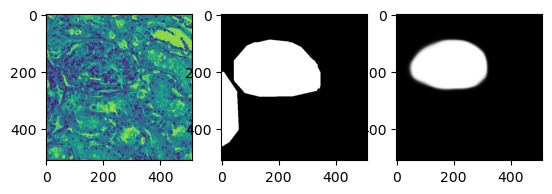

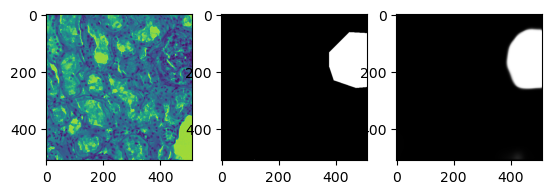

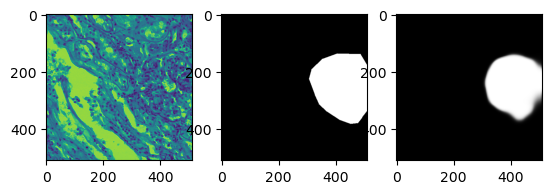

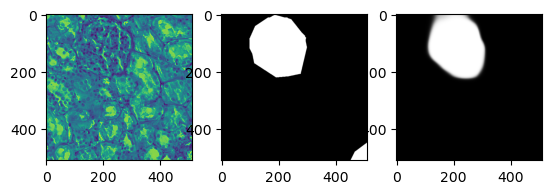

In [35]:
#len(centroid) = 99
for centroid_idx in range(99):
    idx_x = centroid[centroid_idx][0]
    idx_y = centroid[centroid_idx][1]
    center_x = idx_x*512 + 512 // 2
    center_y = idx_y*512 + 512 // 2
    test_patch = Patch(
        center_x = center_x,
        center_y = center_y,
        theta = 0,
        patch_size = 512,
        glomeruli = test_glomeruli,
        image = test_image
    ).render_image()

    test_mask = Patch(
        center_x = center_x,
        center_y = center_y,
        theta = 0,
        patch_size = 512,
        glomeruli = test_glomeruli,
        image = test_image
    ).render_mask()
    out = model.forward(torch.unsqueeze(torch.tensor(test_patch), 0).type(torch.cuda.FloatTensor))

    plt.subplot(1,3,1)
    plt.imshow(test_patch[0])
    plt.subplot(1,3,2)
    plt.imshow(test_mask[0],cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(out.cpu().detach().numpy()[0][0],cmap='gray')
    plt.show()

In [ ]:
for image_name in image_names:
    kidney_label = json.load(open(os.path.join(root_dir, image_name + '.json')))
    for element in kidney_label:
        if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
            label = element['geometry']
            if label['type'] == 'Polygon':
                coordinates = label['coordinates'][0]

#                 Create polygon from label coordinates and plot
                label_polygon = Polygon(coordinates, closed=True, color='red', alpha=0.2)

                glomerulus_sizes.append(shapely.geometry.Polygon(coordinates).area)
                glomerulus_coordinates.append(coordinates)
            
for idx_y in tqdm(range(0, test_image.shape[1], 512)):
    for idx_x in range(0, test_image.shape[2], 512):
        center_x = idx_x + 512 // 2
        center_y = idx_y + 512 // 2
        test_patch = Patch(
            center_x = center_x,
            center_y = center_y,
            theta = 0,
            patch_size = 512,
            glomeruli = test_glomeruli,
            image = test_image
        )
        image = test_patch.render_image()
        label = test_patch.render_mask()